# Predict the profile icon

The model trained for the profile prediction is a ResNet 18 deep layer, which is trained in the profile_icon_classification notebook. We predict profile icons using the Pytorch library to fill in missing information.

In [8]:
# import libraries
import os
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import torch.optim as optim
import matplotlib

%matplotlib inline

In [ ]:
# And set the device for GPU usage
if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

In [ ]:
# Set seeding
torch.manual_seed(420)
np.random.seed(420)

In [ ]:
# Connect google drive to notebook
%load_ext autoreload
%autoreload 2
import sys
from google.colab import drive
from pathlib import Path


drive.mount('content/', force_remount=True)
base = Path('/content/content/My Drive/TdF/Profiles')
sys.path.append(str(base))

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at content/


In [ ]:
# The classes we have
classes = ['p1', 'p2', 'p3', 'p4', 'p5']

## Functions used

In [ ]:
# This function reverses the Pytorch.transforms.Normalize(), which is needed to show the tensor as an image.
def reverse_normalization(tensor_in, mean, std):
  std = torch.FloatTensor(std)
  mean = torch.FloatTensor(mean)
  tensor_out = torch.zeros([tensor_in.shape[0], tensor_in.shape[1], tensor_in.shape[2]], dtype=torch.float)
  tensor_out[0] = tensor_in[0] * std[0] + mean[0]
  tensor_out[1] = tensor_in[1] * std[1] + mean[1]
  tensor_out[2] = tensor_in[2] * std[2] + mean[2]
  return tensor_out

In [ ]:
# Show an image from the dataset
def imshow(img):
  normalised = reverse_normalization(img, mean =[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
  out = normalised.numpy().transpose((1, 2, 0))
  plt.imshow(out)

In [ ]:
# Show a number of random samples from the dataset
# From this question: https://stackoverflow.com/questions/11159436/multiple-figures-in-a-single-window
def show_bunch(dataset, number=5, column='profile_icon'):
  bunch = torch.utils.data.RandomSampler(dataset, replacement=True, num_samples=number)
  
  rows = int(np.ceil(number / 5))
  fig, axeslist = plt.subplots(ncols=5, nrows=rows, figsize=(20, 20))

  for ind, data_index in enumerate(bunch):
    image = dataset[data_index]['image']
    normalised = reverse_normalization(image, mean =[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    img = normalised.numpy().transpose((1, 2, 0))
    label = dataset[data_index][column]
    axeslist.ravel()[ind].imshow(img)
    axeslist.ravel()[ind].set_title(np.round(label.item(), 2))
    axeslist.ravel()[ind].set_axis_off()

  plt.tight_layout()

In [ ]:
# Makes a new resnet18 model, which is not pretrained. The last linear layer is changed to ouput the same number of layers as classes.
# Later the saved parameters are loaded in this model
def new_model():
  model = torchvision.models.resnet18(pretrained=False)
  # Make the last linear layer equal to the dimension of classes
  class_number = len(classes)
  lin = model.fc

  new_lin = nn.Sequential(
      nn.Linear(lin.in_features, class_number, bias=True)
  )

  model.fc = new_lin
  return model

## Datasetclass



In [ ]:
class ProfilesDataset(torch.utils.data.Dataset):
  'Make a profiles dataset'
  def __init__(self, df, root_dir, y_column, transform=None):
    self.profiles_df = df
    self.root_dir = root_dir
    self.transform = transform
    self.y_column = y_column

  def __len__(self):
    return len(self.profiles_df)

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()

    img_name = os.path.join(self.root_dir, self.profiles_df.iloc[idx]['img_name'])
    image = Image.open(img_name)
    profile_icon = self.profiles_df.iloc[idx][self.y_column]
    df_idx = idx

    sample = {'df_idx': df_idx, 'image': image, 'profile_icon': torch.tensor(profile_icon, dtype=torch.long)}

    try:
      if self.transform:
        sample['image'] = self.transform(sample['image'])
    except:
      profile_race = self.profiles_df.iloc[idx]['race']
      print(f'Deze geeft een error:{profile_race}')

    return sample

## Transforms

In [ ]:
# Transforms that are used for the images. The images are resized, converted to a tensor and normalized.
data_transforms = transforms.Compose([
      transforms.Resize((256, 256)),
      transforms.ToTensor(),
      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
      ])

## Load the samples

In [ ]:
# unzip the imgs
!unzip -o -q '/content/content/My Drive/TdF/Profiles/more_data/imgs.zip'

In [ ]:
# Load in the csv file which contains the data
races = pd.read_csv('/content/content/My Drive/TdF/Profiles/races_to_classify.csv', delimiter=';')
# Races to classify is every race without a profile_icon, which is p0
races = races[races['profile_icon'] == 'p0']
races.shape

(136, 8)

In [ ]:
# There are some corrupt images that are not able to be transformed, therefore remove these
test_transform = data_transforms
ind_errors = []
for ind, row in races.iterrows():
  try:
    im = Image.open(row['img_name'])
    test = test_transform(im)
  except Exception as e:
    print(e)
    ind_errors.append(ind)

races = races.drop(ind_errors)
races.shape

cannot identify image file 'imgs/0race-tour-of-austria-2013-stage-3.jpg-large'


(135, 8)

In [ ]:
#Change the class strings to numbers
class_dict = {'p0': 0}
races['profile_icon'] = races['profile_icon'].map(class_dict)

(array([  0.,   0.,   0.,   0.,   0., 135.,   0.,   0.,   0.,   0.]),
 array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5]),
 <a list of 10 Patch objects>)

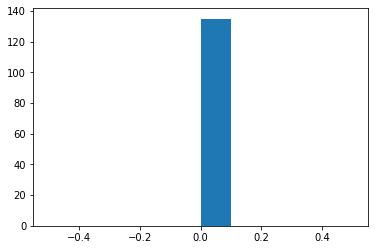

In [ ]:
plt.hist(races['profile_icon'])

In [ ]:
# Reset index
races = races.reset_index()

In [ ]:
# Copy dataframe race
pred_races = races.copy()

## Load the model

In [ ]:
# Create a new model and send it to GPU
model = new_model()
model.to(device)
trained_model = '/content/content/My Drive/TdF/Profiles/more_data/profile_classifier.pt'
# Load the trained model
model.load_state_dict(torch.load(trained_model))
model.eval()
pass # No output

In [ ]:
# Create the dataset
predict_set = ProfilesDataset(df=races, root_dir='', y_column='profile_icon', transform=data_transforms)

In [ ]:
predict_set[0]

{'df_idx': 0,
 'image': tensor([[[2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          ...,
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489]],
 
         [[2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          ...,
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286]],
 
         [[2.6400, 2.6400, 2.6400,  ..., 2.6400, 2.6400, 2.6400],
          [2.6400, 2.6400, 2.6400,  ..., 2.6400, 2.6400, 2.6400],
          [2.6400

In [ ]:
# Load the data set in the loader
predict_loader = torch.utils.data.DataLoader(predict_set, batch_size=1, shuffle=False, num_workers=2)

In [ ]:
# Predict profile_icon and load in the dataframe
for i, data in enumerate(predict_loader, 0):
  input = data['image'].to(device)
  df_idx = data['df_idx']

  output = model(input)
  _, predicted = torch.max(output.data, 1)
  pred_races.loc[df_idx.item(), 'profile_icon'] = predicted.item()

In [ ]:
pred_races.head(5)

,index,Unnamed: 0,Unnamed: 0.1,race,profile_score,point_scale,img_name,profile_icon,location
0,0,172,172,race/etoile-de-besseges/2020/stage-2,0,2.1.Stage,imgs/0race-etoile-de-besseges-2020-stage-2.jpg,2,Alés
1,1,173,173,race/etoile-de-besseges/2020/stage-3,0,2.1.Stage,imgs/0race-etoile-de-besseges-2020-stage-3.jpg,1,Givors
2,2,174,174,race/etoile-de-besseges/2020/stage-4,0,2.1.Stage,imgs/0race-etoile-de-besseges-2020-stage-4.jpg,4,NaN
3,3,4023,4023,race/tour-of-turkey/2015/stage-7,0,2.HC.Stage,imgs/0race-tour-of-turkey-2015-stage-7.png,0,NaN
4,4,4025,4025,race/tour-de-yorkshire/2015/stage-1,0,2.1.Stage,imgs/0race-tour-de-yorkshire-2015-stage-1.jpg,1,NaN


(array([30.,  0., 32.,  0.,  0., 14.,  0., 27.,  0., 32.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <a list of 10 Patch objects>)

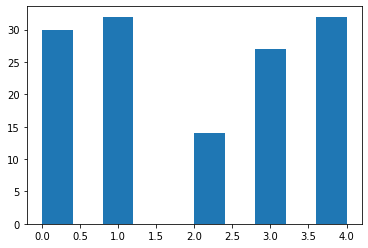

In [ ]:
plt.hist(pred_races['profile_icon'])

In [ ]:
# Save the predictions in a csv file
pred_races.to_csv('/content/content/My Drive/TdF/Profiles/predicted_races.csv', sep=';')